In [0]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import shuffle
import tensorflow as tf

In [0]:
FTRAIN = '/content/gdrive/My Drive/Colab Notebooks/content/gdrive/My Drive/Colab Notebooks/training.csv'
FTEST = '/content/gdrive/My Drive/Colab Notebooks/test.csv'

def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [0]:
def load2d(test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 96, 96, 1)
    return X, y

In [9]:
X, y = load2d()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [5]:
os.path.isfile("drive/Colab Notebooks/test.csv")

False

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

X.shape == (2140, 96, 96, 1); X.min == 0.000; X.max == 1.000
y.shape == (2140, 30); y.min == -0.920; y.max == 0.996


In [0]:
def fc(x, name, in_channels, out_channels, initializer=None, relu=True):
    with tf.variable_scope(name) as scope:
        weights = tf.get_variable(name='weights',
                                  shape=[in_channels, out_channels],
                                  initializer=initializer)
        biases = tf.get_variable(name='biases',
                                 shape=[out_channels],
                                 initializer=initializer)
        act = tf.nn.xw_plus_b(x, weights, biases, name=scope.name)
    if relu:
        act = tf.nn.relu(act)
    return act        

def conv(x, name, kernel, num_filters, padding, stride=1, initializer=None):
    with tf.variable_scope(name) as scope:
        conv_ = tf.layers.conv2d(x, num_filters, kernel, stride, padding)
        conv_ = tf.nn.relu(conv_, name=scope.name)
    return conv_

In [0]:
def inference(x):
    # conv1
    conv1 = conv(x, 'conv1', kernel=3, num_filters=32, padding='VALID')
    pool1 = tf.layers.max_pooling2d(conv1, 2, 2, padding='SAME', name='pool1')
    dropout1 = tf.layers.dropout(pool1, rate=0.1, name='dropout1')
    # conv2
    conv2 = conv(dropout1, 'conv2', kernel=2, num_filters=64, padding='VALID')
    pool2 = tf.layers.max_pooling2d(conv2, 2, 2, padding='SAME', name='pool2')
    dropout2 = tf.layers.dropout(pool2, rate=0.2, name='dropout2')
    # conv3
    conv3 = conv(dropout2, 'conv3', kernel=2, num_filters=128, padding='VALID')
    pool3 = tf.layers.max_pooling2d(conv3, 2, 2, padding='SAME', name='pool3')
    dropout3 = tf.layers.dropout(pool3, rate=0.3, name='dropout3')
    # reshape
    dropout3 = tf.reshape(dropout3, [-1, 11 * 11 * 128])
    # fc4
    fc4 = fc(dropout3, 'fc4', 11 * 11 * 128, 1000)
    dropout4 = tf.layers.dropout(fc4, rate=0.5, name='dropout4')
    # fc5
    fc5 = fc(dropout4, 'fc5', 1000, 1000)
    # output
    output = fc(fc5, 'output', 1000, 30, relu=False)
    return output

In [0]:
def loss(scores, labels):
    loss = tf.losses.mean_squared_error(labels,
                                        scores)
    return loss

In [0]:
def train(loss, learning_rate, momentum):
    lr_var_opt = tf.train.MomentumOptimizer(learning_rate, momentum)
    lr_var_grads = lr_var_opt.compute_gradients(loss)
    apply_gradient_op = lr_var_opt.apply_gradients(lr_var_grads)
    return apply_gradient_op

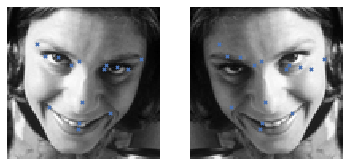

In [15]:
import matplotlib.pyplot as pyplot

X_flipped = X[:, :, ::-1, :]  # simple slice to flip all images

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

# plot two images:
fig = pyplot.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(X[1], y[1], ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(X_flipped[1], y[1], ax)
pyplot.show()

In [16]:
flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
    ]

df = pd.read_csv(os.path.expanduser(FTRAIN))
for i, j in flip_indices:
    print("# {} -> {}".format(df.columns[i], df.columns[j]))

# left_eye_center_x -> right_eye_center_x
# left_eye_center_y -> right_eye_center_y
# left_eye_inner_corner_x -> right_eye_inner_corner_x
# left_eye_inner_corner_y -> right_eye_inner_corner_y
# left_eye_outer_corner_x -> right_eye_outer_corner_x
# left_eye_outer_corner_y -> right_eye_outer_corner_y
# left_eyebrow_inner_end_x -> right_eyebrow_inner_end_x
# left_eyebrow_inner_end_y -> right_eyebrow_inner_end_y
# left_eyebrow_outer_end_x -> right_eyebrow_outer_end_x
# left_eyebrow_outer_end_y -> right_eyebrow_outer_end_y
# mouth_left_corner_x -> mouth_right_corner_x
# mouth_left_corner_y -> mouth_right_corner_y


In [0]:
import random

def flip_image(x, labels):
    is_flip = bool(random.getrandbits(1))
    if is_flip:
        x = x[:, :, ::-1, :]
        
        values = []
        for i in range(labels.shape[1]):
            label = labels[:, i]
            if i % 2 == 0:
                values.append(label * -1)
            else:
                values.append(label)
        labels = tf.stack(values, axis=1)
        
        # Swap places, e.g. left_eye_center_x -> right_eye_center_x
        new_labels = []
        for i in range (30):
            got = False
            for a, b in flip_indices:
                if a == i:
                    label = labels[:, b]
                    new_labels.append(label)
                    got = True
                    break
                elif b == i:
                    label = labels[:, a]
                    new_labels.append(label)
                    got = True
                    break
            if got is False:
                label = labels[:, i]
                new_labels.append(label)          
        labels = tf.stack(new_labels, axis=1)
    return x, labels

In [0]:
from datetime import datetime
import time 

NUM_EPOCHS = 10000
NUM_STEPS = 17
BATCH = 128

def train_():
    with tf.Graph().as_default():
        x = tf.placeholder(dtype='float32',
                           shape=[None, 96, 96, 1],
                           name='x')
        labels = tf.placeholder(dtype='float32',
                                shape=[None, 30],
                                name='labels')
        dataset = tf.data.Dataset.from_tensor_slices((x, labels)).batch(BATCH).map(flip_image)
        iterator = dataset.make_initializable_iterator()
        
        learning_rate = tf.placeholder(tf.float32)
        momentum = tf.placeholder(tf.float32)
        
        next_x, next_y = iterator.get_next()
        scores = inference(next_x)
        total_loss = loss(scores, next_y)
        train_op = train(total_loss, learning_rate, momentum)

        saver = tf.train.Saver()

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(NUM_EPOCHS):
                sess.run(iterator.initializer, feed_dict={x: X, labels: y})
                lr = (0.03 * (NUM_EPOCHS - i) + i * 0.0001) / NUM_EPOCHS
                mom = (0.9 * (NUM_EPOCHS - i) + i * 0.999) / NUM_EPOCHS
                for j in range(0, NUM_STEPS):
                    loss_, _ = sess.run([total_loss, train_op], feed_dict={learning_rate: lr, momentum: mom})
                print(loss_)
                if (i % 100 == 0):
                    dest_directory = os.path.join('/content/gdrive/My Drive/Colab Notebooks/face_data_conv', 'face_train')
                    checkpoint_name = os.path.join(dest_directory,
                                               'model_epoch'+str(i)+'.ckpt')
                    save_path = saver.save(sess, checkpoint_name)
                    print("{} Model checkpoint saved at {}".format(datetime.now(),
                                                               checkpoint_name))

In [23]:
train_()

0.01911148
2018-10-02 10:44:59.985327 Model checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/face_data_conv/face_train/model_epoch0.ckpt
0.0071951156
0.004938586
0.0044827387
0.004362908
0.0042947936
0.004256357
0.004224621
0.0042012166
0.0041815727
0.004164807
0.0041500498
0.0041365772
0.004124884
0.004114468
0.0041048224
0.0040957853
0.004087507
0.0040796986
0.004072143
0.004064904
0.0040579773
0.0040511703
0.004044424
0.004037628
0.004030912
0.0040241065
0.004017195
0.004010089
0.0040029376
0.003995554
0.0039880406
0.0039805267
0.0039727464
0.003964808
0.0039566904
0.0039483383
0.0039398153
0.0039308383
0.003921342
0.003911078
0.0039012602
0.0038919693
0.00388263
0.003873154
0.003863204
0.003852941
0.0038421606
0.0038314667
0.0038203546
0.0038087945
0.0037971234
0.0037847152
0.0037720995
0.0037592298
0.0037459708
0.0037324277
0.0037184027
0.003704241
0.003689457
0.0036742638
0.0036583445
0.0036427488
0.0036273787
0.0036117183
0.0035955464
0.0035790526
0.003562
0.00354494

KeyboardInterrupt: ignored

In [0]:
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

In [25]:
X_test, _ = load2d(test=True)
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X_test.shape, X_test.min(), X_test.max()))

ImageId    1783
Image      1783
dtype: int64
X.shape == (1783, 96, 96, 1); X.min == 0.000; X.max == 1.000


In [0]:
EVAL_NUM_STEPS = 14
answer = np.zeros([1783, 30])

def eval_():
    with tf.Graph().as_default():
        x = tf.placeholder(dtype='float32',
                           shape=[None, 96, 96, 1],
                           name='x')
        dataset = tf.data.Dataset.from_tensor_slices(x).batch(BATCH)
        iterator = dataset.make_initializable_iterator()

        next_x = iterator.get_next()
        scores = inference(next_x)
        
        saver = tf.train.Saver()

        with tf.Session() as sess:
            sess.run(iterator.initializer, feed_dict={x: X_test})
            ckpt = tf.train.get_checkpoint_state('/content/gdrive/My Drive/Colab Notebooks/face_data_conv/face_train')
            if ckpt and ckpt.model_checkpoint_path:
                # Restores from checkpoint
                saver.restore(sess, ckpt.model_checkpoint_path)
            else:
                print('No checkpoint file found')
                return    
            count = 0
            for j in range(0, EVAL_NUM_STEPS):
                ans = sess.run(scores)
                for i in range(0, ans.shape[0]):
                    answer[count] = ans[i, :]
                    count = count + 1
            print(count)

In [32]:
eval_()

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/face_data_conv/face_train/model_epoch5000.ckpt
1783


In [33]:
answer[1782, :]

array([ 0.39471883, -0.1468024 , -0.36391646, -0.229442  ,  0.21853054,
       -0.14213319,  0.56132656, -0.11737128, -0.21540913, -0.19235836,
       -0.52857304, -0.23479095,  0.15240477, -0.30997416,  0.71917343,
       -0.22472699, -0.1340867 , -0.30414632, -0.65628433, -0.33418325,
       -0.06614316,  0.23189983,  0.26902154,  0.72831851, -0.35440862,
        0.6774075 , -0.05282414,  0.62543184, -0.08055896,  0.83369988])

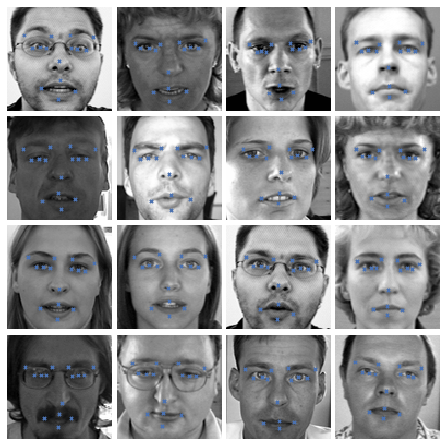

In [34]:
import matplotlib.pyplot as pyplot

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], answer[i], ax)

pyplot.show()